In [411]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd   
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss

from lightgbm import LGBMClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm

In [415]:
train = pd.read_csv('../Data/train.csv')
test = pd.read_csv('../Data/test.csv')
submission = pd.read_csv('../Data/sample_submission.csv')
sub_train = train

<AxesSubplot:>

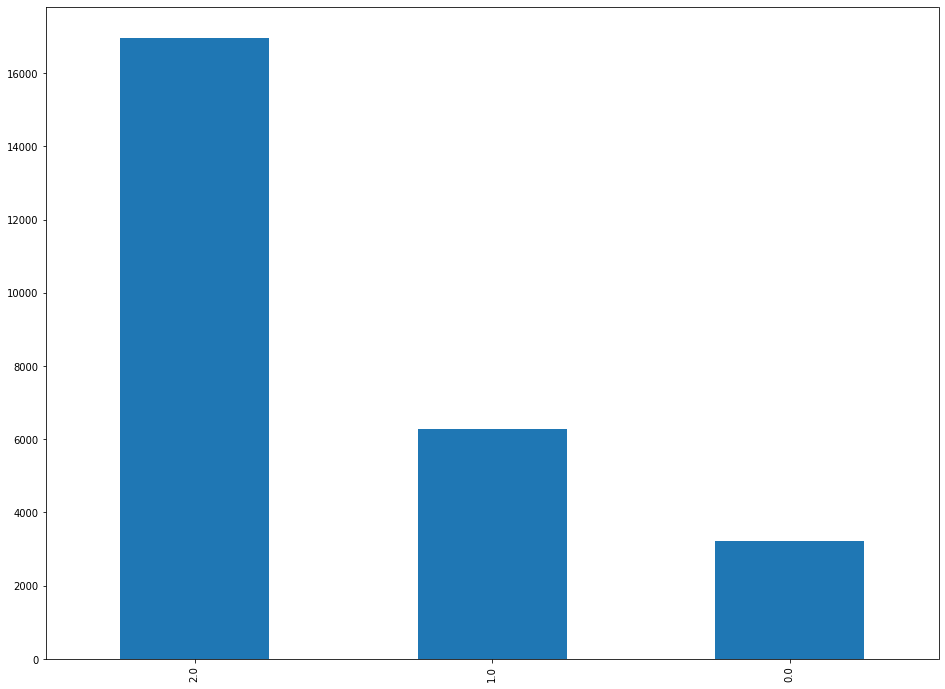

In [416]:
train['credit'].value_counts().plot(kind ='bar')

# Feature 설명

index   
gender: 성별   (o)
car: 차량 소유 여부   (o)
reality: 부동산 소유 여부   (o)
child_num: 자녀 수   
income_total: 연간 소득  (o)
income_type: 소득 분류   
['Commercial associate', 'Working', 'State servant', 'Pensioner', 'Student']   
edu_type: 교육 수준   
['Higher education' ,'Secondary / secondary special', 'Incomplete higher', 'Lower secondary', 'Academic degree']   
family_type: 결혼 여부   
['Married', 'Civil marriage', 'Separated', 'Single / not married', 'Widow']   
house_type: 생활 방식   
['Municipal apartment', 'House / apartment', 'With parents','Co-op apartment', 'Rented apartment', 'Office apartment']   
DAYS_BIRTH: 출생일   (o)
데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 하루 전에 태어났음을 의미   
DAYS_EMPLOYED: 업무 시작일   (o)   
데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 하루 전부터 일을 시작함을 의미,양수 값은 고용되지 않은 상태를 의미함   
FLAG_MOBIL: 핸드폰 소유 여부  (o) 
work_phone: 업무용 전화 소유 여부   (o)
phone: 전화 소유 여부  (o) 
email: 이메일 소유 여부   (o)
occyp_type: 직업 유형	   												
family_size: 가족 규모  (o) 
begin_month: 신용카드 발급 월 데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 한 달 전에 신용카드를 발급함을 의미 (o)     

credit: 사용자의 신용카드 대금 연체를 기준으로 한 신용도   
=> 낮을 수록 높은 신용의 신용카드 사용자를 의미함   



In [417]:
train.head(5)

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,NaN,2.0,-6.0,1.0
1,1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0
2,2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,Managers,2.0,-22.0,2.0
3,3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,1,0,1,0,Sales staff,2.0,-37.0,0.0
4,4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,1,0,0,0,Managers,2.0,-26.0,2.0


In [418]:
train['identity'] = [str(i) + str(j) + str(k) + str(l) + str(m)  for i,j,k,l,m, in zip(train['gender'],train['income_total'],train['income_type'],train['DAYS_BIRTH'],train['DAYS_EMPLOYED'])]
test['identity'] = [str(i) + str(j) + str(k) + str(l) + str(m) for i,j,k,l,m, in zip(test['gender'],test['income_total'],test['income_type'],test['DAYS_BIRTH'],test['DAYS_EMPLOYED'])]

print(f"train set 중복데이터가 아닌 사람의 수 : {sum(train['identity'].value_counts()==1)}명")
print(f"test set 중복데이터가 아닌 사람의 수 : {sum(test['identity'].value_counts()==1)}명")
print('-'*60)
print(f"train set 동일인물의 중복데이터로 추정되는 사람의 수 : {sum(train['identity'].value_counts()>=2)}명")
print(f"test set 동일인물의 중복데이터로 추정되는 사람의 수 : {sum(test['identity'].value_counts()>=2)}명")

train set 중복데이터가 아닌 사람의 수 : 3209명
test set 중복데이터가 아닌 사람의 수 : 3103명
------------------------------------------------------------
train set 동일인물의 중복데이터로 추정되는 사람의 수 : 5518명
test set 동일인물의 중복데이터로 추정되는 사람의 수 : 2468명


In [419]:
""" refund_case_1 = []
for i in tqdm(range(len(refund.index))):
    subset = dataset.iloc[refund.index[i]-1 : refund.index[i] + 1]
    if subset['amount'].sum() == 0:
        refund_case_1.append(refund.index[i]) # 환불 건의 index 를 추출합니다. index 41과 같은 건을 모두 추출
    else:
        pass """

" refund_case_1 = []\nfor i in tqdm(range(len(refund.index))):\n    subset = dataset.iloc[refund.index[i]-1 : refund.index[i] + 1]\n    if subset['amount'].sum() == 0:\n        refund_case_1.append(refund.index[i]) # 환불 건의 index 를 추출합니다. index 41과 같은 건을 모두 추출\n    else:\n        pass "

In [420]:
subset = train['identity'].value_counts() > 1
subset

F297000.0Commercial associate-15519-3234     True
F157500.0State servant-12676-1350            True
M225000.0Working-16768-3088                  True
M112500.0Working-9952-1613                   True
F225000.0Working-12322-3717                  True
                                            ...  
F175950.0Working-20462-1881                 False
F180000.0Working-13638-3809                 False
F67500.0Working-12176-5316                  False
F112500.0Working-9733-187                   False
F126000.0State servant-19292-1371           False
Name: identity, Length: 8727, dtype: bool

In [351]:
drop_list = []

for i in range(len(subset)):
    if subset.values[i] == True:
        drop_list.append(subset.index[i])
    else:
        pass

In [352]:
confusion_list = []
for i in range(len(drop_list)):
    if len(train.loc[train['identity'] == drop_list[i]].sort_values(by=['begin_month'])['credit'].unique()) > 2:
        confusion_list.append(drop_list[i])
    else:
        pass

In [353]:
for i in range(len(confusion_list)):
    train.loc[train['identity'] == confusion_list[1], 'credit'] = statistics.mode(train.loc[train['identity'] == confusion_list[i], 'credit'])

In [340]:
import statistics

In [221]:
for i in tqdm(range(len(confusion_list))):
    train = train.drop(index = train.loc[train['identity'] == confusion_list[i]].sort_values(by=['begin_month']).index[1:] , axis=0)

100%|██████████| 2839/2839 [00:19<00:00, 148.63it/s]


In [354]:
train.shape

(26457, 21)

In [355]:
train = train.drop('identity', axis = 1)
test = test.drop('identity', axis = 1)

# DEF 모음

In [356]:
def box_value(col):
    Q1 = abs(train[train[col] > 0][col].quantile(0.25))
    Q2 = abs(train[train[col] > 0][col].quantile(0.50))
    Q3 = abs(train[train[col] > 0][col].quantile(0.75))
    IQR = Q3 - Q1

    return Q1, Q2, Q3, IQR

# Preprocessing

In [357]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26457 entries, 0 to 26456
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          26457 non-null  int64  
 1   gender         26457 non-null  object 
 2   car            26457 non-null  object 
 3   reality        26457 non-null  object 
 4   child_num      26457 non-null  int64  
 5   income_total   26457 non-null  float64
 6   income_type    26457 non-null  object 
 7   edu_type       26457 non-null  object 
 8   family_type    26457 non-null  object 
 9   house_type     26457 non-null  object 
 10  DAYS_BIRTH     26457 non-null  int64  
 11  DAYS_EMPLOYED  26457 non-null  int64  
 12  FLAG_MOBIL     26457 non-null  int64  
 13  work_phone     26457 non-null  int64  
 14  phone          26457 non-null  int64  
 15  email          26457 non-null  int64  
 16  occyp_type     18286 non-null  object 
 17  family_size    26457 non-null  float64
 18  begin_

## **0. FLAG_MOBIL**

In [358]:
train['FLAG_MOBIL'] = train['FLAG_MOBIL'] - train['work_phone']*0.3 - train['phone']*0.3 - train['email']*0.3
test['FLAG_MOBIL'] = test['FLAG_MOBIL'] - test['work_phone']*0.3 - test['phone']*0.3 - test['email']*0.3

In [359]:
train['FLAG_MOBIL'].value_counts()

1.0    14542
0.7     7962
0.4     3675
0.1      278
Name: FLAG_MOBIL, dtype: int64

In [360]:
train['FLAG_MOBIL'] = train['FLAG_MOBIL'].replace([1,0.7,0.39999999999999997,0.09999999999999998], ['A','B','C','D'])
test['FLAG_MOBIL'] = test['FLAG_MOBIL'].replace([1,0.7,0.39999999999999997,0.09999999999999998], ['A','B','C','D'])

## **1. DAYS_EMPLOYED**

In [361]:
train[train['DAYS_EMPLOYED'] > 0]['DAYS_EMPLOYED'].value_counts()

365243    4438
Name: DAYS_EMPLOYED, dtype: int64

In [362]:
train.loc[train['DAYS_EMPLOYED'] > 0,'DAYS_EMPLOYED'] = 0
test.loc[test['DAYS_EMPLOYED'] > 0,'DAYS_EMPLOYED'] = 0

<AxesSubplot:ylabel='Frequency'>

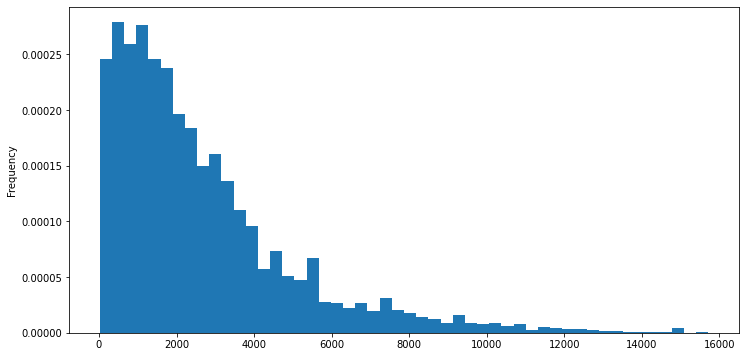

In [363]:
abs(train.loc[train['DAYS_EMPLOYED'] < 0,'DAYS_EMPLOYED']).plot(kind='hist',bins=50,density=True)

In [364]:
train.loc[train['DAYS_EMPLOYED'] < 0,'DAYS_EMPLOYED'] = train.loc[train['DAYS_EMPLOYED'] < 0,'DAYS_EMPLOYED'].abs()
test.loc[test['DAYS_EMPLOYED'] < 0,'DAYS_EMPLOYED'] = test.loc[test['DAYS_EMPLOYED'] < 0,'DAYS_EMPLOYED'].abs()
train['DAYS_EMPLOYED']

0        4709
1        1540
2        4434
3        2092
4        2105
         ... 
26452    1984
26453    2475
26454    2015
26455     107
26456    1013
Name: DAYS_EMPLOYED, Length: 26457, dtype: int64

In [321]:
plt.rcParams['figure.figsize'] = (12,6)

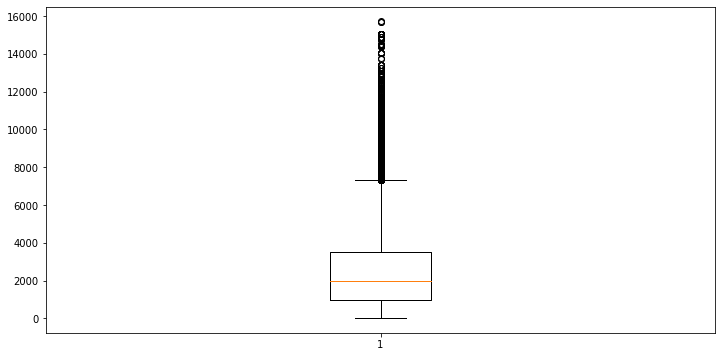

In [365]:
plt.boxplot(abs(train[train['DAYS_EMPLOYED'] > 0]['DAYS_EMPLOYED']))
plt.show()

In [366]:
Q1 = abs(train[train['DAYS_EMPLOYED'] > 0]['DAYS_EMPLOYED'].quantile(0.25))
Q2 = abs(train[train['DAYS_EMPLOYED'] > 0]['DAYS_EMPLOYED'].quantile(0.50))
Q3 = abs(train[train['DAYS_EMPLOYED'] > 0]['DAYS_EMPLOYED'].quantile(0.75))
IQR = Q3 - Q1

print(f'Q1 : {Q1} Q3 : {Q3} IQR : {IQR}')

Q1 : 969.5 Q3 : 3506.0 IQR : 2536.5


In [367]:
train.loc[(train['DAYS_EMPLOYED'] <= Q1 - 1.5 * IQR) | (train['DAYS_EMPLOYED'] >= Q3 + 1.5 *IQR), 'DAYS_EMPLOYED'] = Q3
test.loc[(test['DAYS_EMPLOYED'] <= Q1 - 1.5 * IQR) | (test['DAYS_EMPLOYED'] >= Q3 + 1.5 *IQR), 'DAYS_EMPLOYED'] = Q3

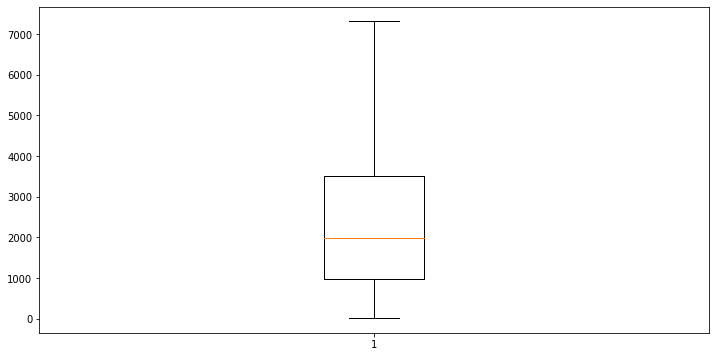

In [368]:
plt.boxplot(abs(train[train['DAYS_EMPLOYED'] > 0]['DAYS_EMPLOYED']))
plt.show()

In [25]:
def dayEMP_category(day_ep):
    ep = ''
    if day_ep == 0: ep = 0
    elif day_ep <= Q1: ep = 1
    elif day_ep <= Q2: ep = 2
    elif day_ep <= Q3: ep = 3
    elif day_ep > Q3: ep = 4
       
    return ep


In [26]:
train['DAYS_EMPLOYED'] = train['DAYS_EMPLOYED'].apply(lambda x : dayEMP_category(x))
test['DAYS_EMPLOYED'] = test['DAYS_EMPLOYED'].apply(lambda x : dayEMP_category(x))

In [27]:
train['DAYS_EMPLOYED'] = train['DAYS_EMPLOYED'].replace({0 : 'A', 1 : 'B', 2 : 'C', 3 : 'D', 4 : 'E'})
test['DAYS_EMPLOYED'] = test['DAYS_EMPLOYED'].replace({0 : 'A', 1 : 'B', 2 : 'C', 3 : 'D', 4 : 'E'})

In [369]:
train['DAYS_EMPLOYED'].value_counts()

0.0       4438
3506.0    1263
401.0       57
1539.0      47
200.0       45
          ... 
549.0        1
5404.0       1
2160.0       1
738.0        1
3189.0       1
Name: DAYS_EMPLOYED, Length: 3122, dtype: int64

## Begin_month

<AxesSubplot:ylabel='Frequency'>

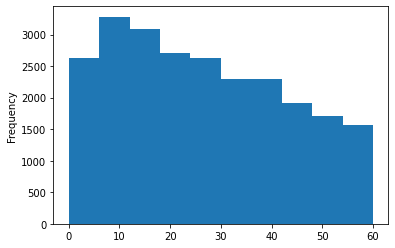

In [29]:
abs(train['begin_month']).plot(kind='hist', bins = 10)

In [370]:
train['begin_month'] = train['begin_month'].abs()
test['begin_month'] = test['begin_month'].abs()

In [991]:
begin_catagory = [0,1,1,2,2,3,3,4,4,4]
train['begin_month'] = pd.cut(train['begin_month'], bins = 10, labels= begin_catagory, ordered= False)
test['begin_month'] = pd.cut(test['begin_month'], bins = 10, labels= begin_catagory, ordered= False)

In [992]:
train['begin_month'] = train['begin_month'].replace({0 : 'A', 1 : 'B', 2 : 'C', 3 : 'D', 4 : 'E'})
test['begin_month'] = test['begin_month'].replace({0 : 'A', 1 : 'B', 2 : 'C', 3 : 'D', 4 : 'E'})

In [371]:
train['begin_month'].value_counts()

7.0     662
11.0    617
8.0     612
3.0     593
6.0     591
       ... 
58.0    244
59.0    242
60.0    235
0.0     231
57.0    228
Name: begin_month, Length: 61, dtype: int64

## income_total

<AxesSubplot:ylabel='Frequency'>

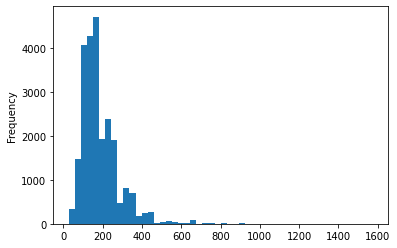

In [32]:
(train['income_total']/1000).plot(kind = 'hist', bins = 50)

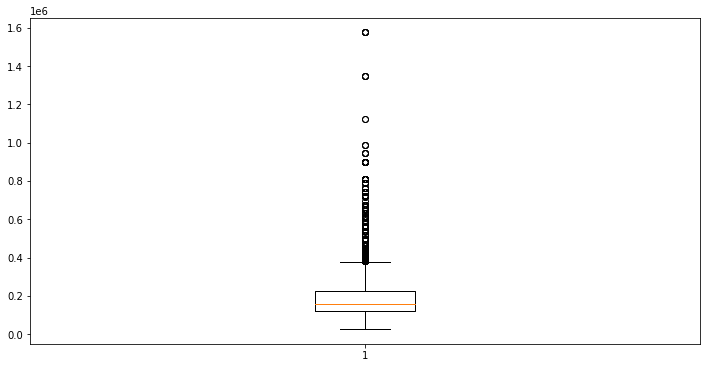

In [372]:
plt.boxplot(train['income_total'])
plt.show()

In [373]:
Q1 = box_value('income_total')[0]
Q2 = box_value('income_total')[1]
Q3 = box_value('income_total')[2]
IQR = box_value('income_total')[3]

In [374]:
train.loc[(train['income_total'] <= Q1 - 1.5 * IQR) | (train['income_total'] >= Q3 + 1.5 *IQR), 'income_total'] = Q3 + IQR/3
test.loc[(test['income_total'] <= Q1 - 1.5 * IQR) | (test['income_total'] >= Q3 + 1.5 *IQR), 'income_total'] = Q3 + IQR/3

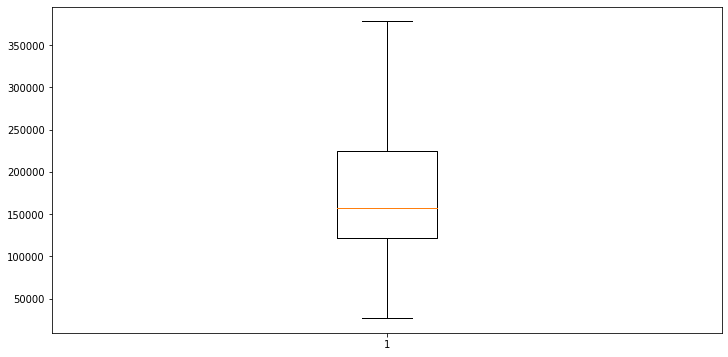

In [375]:
plt.boxplot(train['income_total'])
plt.show()

In [999]:
""" def box_category(value):
    ep = ''
    if value <= Q1: ep = 0
    elif value <= Q2: ep = 1
    elif value <= Q3: ep = 2
    elif value > Q3: ep = 3
       
    return ep

train['income_total'] = train['income_total'].apply(lambda x : box_category(x))
test['income_total'] = test['income_total'].apply(lambda x : box_category(x)) """

" def box_category(value):\n    ep = ''\n    if value <= Q1: ep = 0\n    elif value <= Q2: ep = 1\n    elif value <= Q3: ep = 2\n    elif value > Q3: ep = 3\n       \n    return ep\n\ntrain['income_total'] = train['income_total'].apply(lambda x : box_category(x))\ntest['income_total'] = test['income_total'].apply(lambda x : box_category(x)) "

In [1000]:
""" train['income_total'] = train['income_total'].replace({0 : 'A', 1 : 'B', 2 : 'C', 3 : 'D'})
test['income_total'] = test['income_total'].replace({0 : 'A', 1 : 'B', 2 : 'C', 3 : 'D'}) """

" train['income_total'] = train['income_total'].replace({0 : 'A', 1 : 'B', 2 : 'C', 3 : 'D'})\ntest['income_total'] = test['income_total'].replace({0 : 'A', 1 : 'B', 2 : 'C', 3 : 'D'}) "

In [376]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

train['income_total'] = scaler.fit_transform(train['income_total'].values.reshape(-1,1))
test['income_total'] = scaler.transform(test['income_total'].values.reshape(-1,1))

In [377]:
test['income_total'].values

array([0.24358974, 0.30769231, 0.12071795, ..., 0.75641026, 0.43589744,
       0.69230769])

In [1003]:
""" scaler.fit(test['income_total'].values.reshape(-1,1))
test['income_total'] = scaler.transform(test['income_total'].values.reshape(-1,1)) """

" scaler.fit(test['income_total'].values.reshape(-1,1))\ntest['income_total'] = scaler.transform(test['income_total'].values.reshape(-1,1)) "

## Gender, Car, Reality

In [1004]:
""" train['gender'] = train['gender'].replace(['F','M'],[0,1])
test['gender'] = test['gender'].replace(['F','M'],[0,1])
print('gender :')
print(train['gender'].value_counts())
print('--------------')

print('Having a car or not : ')
train['car'] = train['car'].replace(['N','Y'],[0,1])
test['car'] = test['car'].replace(['N','Y'],[0,1])
print(train['car'].value_counts())
print('--------------')

print('Having house reality or not: ')
train['reality'] = train['reality'].replace(['N','Y'],[0,1])
test['reality'] = test['reality'].replace(['N','Y'],[0,1])
print(train['reality'].value_counts())
print('--------------') """

" train['gender'] = train['gender'].replace(['F','M'],[0,1])\ntest['gender'] = test['gender'].replace(['F','M'],[0,1])\nprint('gender :')\nprint(train['gender'].value_counts())\nprint('--------------')\n\nprint('Having a car or not : ')\ntrain['car'] = train['car'].replace(['N','Y'],[0,1])\ntest['car'] = test['car'].replace(['N','Y'],[0,1])\nprint(train['car'].value_counts())\nprint('--------------')\n\nprint('Having house reality or not: ')\ntrain['reality'] = train['reality'].replace(['N','Y'],[0,1])\ntest['reality'] = test['reality'].replace(['N','Y'],[0,1])\nprint(train['reality'].value_counts())\nprint('--------------') "

## DAYS_BIRTH

In [378]:
train['DAYS_BIRTH'] = (train['DAYS_BIRTH'].abs()/365).astype(int)
test['DAYS_BIRTH'] = (test['DAYS_BIRTH'].abs()/365).astype(int)

<AxesSubplot:ylabel='Frequency'>

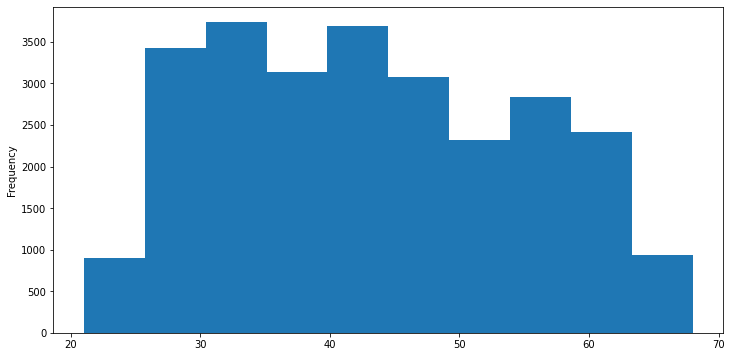

In [379]:
train['DAYS_BIRTH'].plot(kind='hist')

In [1007]:
def birth_catagory(value):
    ep = ''
    if value <= 30: ep = 'A'
    elif value <= 40: ep = 'B'
    elif value <= 50: ep = 'C'
    elif value <= 60: ep = 'D'
    elif value < 70: ep = 'E'
       
    return ep

In [1008]:
train['DAYS_BIRTH'] = train['DAYS_BIRTH'].apply(lambda x : birth_catagory(x))
test['DAYS_BIRTH'] = test['DAYS_BIRTH'].apply(lambda x : birth_catagory(x))

In [380]:
train['DAYS_BIRTH'].value_counts()

37    903
27    836
40    820
28    809
34    796
39    795
32    772
33    753
41    750
38    749
42    733
35    724
43    717
30    716
31    691
36    686
46    674
29    671
44    671
47    654
48    631
51    625
54    619
57    611
50    593
59    587
56    586
60    584
45    577
53    564
58    554
49    542
52    539
55    461
62    454
63    396
61    389
26    388
64    386
25    358
24    271
65    240
66    199
23    159
22    109
67     85
68     23
21      7
Name: DAYS_BIRTH, dtype: int64

## family_size

In [381]:
train['family_size'].value_counts()

2.0     14106
1.0      5109
3.0      4632
4.0      2260
5.0       291
6.0        44
7.0         9
15.0        3
9.0         2
20.0        1
Name: family_size, dtype: int64

In [382]:
test['family_size'].value_counts()

2.0    5357
1.0    1878
3.0    1789
4.0     846
5.0     106
6.0      14
7.0      10
Name: family_size, dtype: int64

In [383]:
train['family_size'] = train['family_size'].replace([5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20], 4)
test['family_size'] = test['family_size'].replace([5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20], 4)

In [384]:
train['family_size'] = train['family_size'].replace({1 : 'A', 2 : 'B', 3 : 'C', 4 : 'D'})
test['family_size'] = test['family_size'].replace({1 : 'A', 2 : 'B', 3 : 'C', 4 : 'D'})

In [385]:
train['family_size'].value_counts()

B    14106
A     5109
C     4632
D     2610
Name: family_size, dtype: int64

## work_phone, phone, email, FLAG_MOBIL

In [386]:
train['work_phone'] = train['work_phone'].replace([0,1], ['N','Y'])
test['work_phone'] = test['work_phone'].replace([0,1], ['N','Y'])
print('work_phone :')
print(train['work_phone'].value_counts())
print('--------------')

train['phone'] = train['phone'].replace([0,1], ['N','Y'])
test['phone'] = test['phone'].replace([0,1], ['N','Y'])
print(train['phone'].value_counts())
print('--------------')


train['email'] = train['email'].replace([0,1], ['N','Y'])
test['email'] = test['email'].replace([0,1], ['N','Y'])
print(train['email'].value_counts())
print('--------------')

work_phone :
N    20511
Y     5946
Name: work_phone, dtype: int64
--------------
N    18672
Y     7785
Name: phone, dtype: int64
--------------
N    24042
Y     2415
Name: email, dtype: int64
--------------


## child_num

In [387]:
train['child_num'].value_counts()

0     18340
1      5386
2      2362
3       306
4        47
5        10
14        3
7         2
19        1
Name: child_num, dtype: int64

In [388]:
test['child_num'].value_counts()

0    6861
1    2106
2     894
3     113
4      16
5      10
Name: child_num, dtype: int64

In [389]:
def child_category(value):
    ep = ''
    if value == 0: ep = 'Z'
    elif value == 1: ep = 'O'
    elif value == 2: ep = 'T'
    elif value >= 3: ep = 'M'
    
    return ep

In [390]:
train['child_num'] = train['child_num'].apply(lambda x : child_category(x))
test['child_num'] = test['child_num'].apply(lambda x : child_category(x))

In [391]:
train['child_num'].value_counts()

Z    18340
O     5386
T     2362
M      369
Name: child_num, dtype: int64

# **데이터 중간 저장**

In [1021]:
""" train.to_csv('../Data/Catdata.csv')
test.to_csv('../Data/Cattest.csv') """


" train.to_csv('../Data/Catdata.csv')\ntest.to_csv('../Data/Cattest.csv') "

In [392]:
from sklearn.cluster import KMeans

train['occyp_type'] = train['occyp_type'].fillna('Secret')
test['occyp_type'] = test['occyp_type'].fillna('Secret')

subset = pd.crosstab(train['occyp_type'] , train['income_total'])
subset['Total'] = subset.sum(axis=1)

subset = subset.div(subset['Total'].values, axis = 0)
subset = subset.drop('Total', axis = 1)
subset = subset.drop('Secret', axis = 0)

kmeans = KMeans(n_clusters= 3)
kmeans.fit(subset)

KMeans(n_clusters=3)

In [393]:
subset['Cluster'] = kmeans.labels_ 

In [394]:
subset.loc[subset['Cluster'] == 0].index

Index(['Accountants', 'Cleaning staff', 'Cooking staff', 'Core staff',
       'Drivers', 'HR staff', 'High skill tech staff', 'IT staff', 'Laborers',
       'Low-skill Laborers', 'Managers', 'Medicine staff',
       'Private service staff', 'Sales staff', 'Secretaries',
       'Security staff'],
      dtype='object', name='occyp_type')

In [395]:
train['occyp_type'] = train['occyp_type'].replace('Secret' , 'A')
train['occyp_type'] = train['occyp_type'].replace(['Accountants', 'Core staff', 'Drivers', 'HR staff','High skill tech staff', 'IT staff', 'Laborers','Private service staff', 'Sales staff', 'Security staff'],'B')
train['occyp_type'] = train['occyp_type'].replace(['Cleaning staff', 'Cooking staff', 'Low-skill Laborers','Medicine staff', 'Secretaries', 'Waiters/barmen staff'], 'C')
train['occyp_type'] = train['occyp_type'].replace(['Managers','Realty agents'], 'D')

In [396]:
test['occyp_type'] = test['occyp_type'].replace('Secret', 'A')
test['occyp_type'] = test['occyp_type'].replace(['Accountants', 'Core staff', 'Drivers', 'HR staff','High skill tech staff', 'IT staff', 'Laborers','Private service staff', 'Sales staff', 'Security staff'],'B')
test['occyp_type'] = test['occyp_type'].replace(['Cleaning staff', 'Cooking staff', 'Low-skill Laborers','Medicine staff', 'Secretaries', 'Waiters/barmen staff'], 'C')
test['occyp_type'] = test['occyp_type'].replace(['Managers','Realty agents'], 'D')

In [397]:
train['occyp_type'].value_counts()

B    13984
A     8171
D     2230
C     2072
Name: occyp_type, dtype: int64

In [398]:
test['occyp_type'].value_counts()

B    5146
A    3152
D     861
C     841
Name: occyp_type, dtype: int64

In [399]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26457 entries, 0 to 26456
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          26457 non-null  int64  
 1   gender         26457 non-null  object 
 2   car            26457 non-null  object 
 3   reality        26457 non-null  object 
 4   child_num      26457 non-null  object 
 5   income_total   26457 non-null  float64
 6   income_type    26457 non-null  object 
 7   edu_type       26457 non-null  object 
 8   family_type    26457 non-null  object 
 9   house_type     26457 non-null  object 
 10  DAYS_BIRTH     26457 non-null  int32  
 11  DAYS_EMPLOYED  26457 non-null  float64
 12  FLAG_MOBIL     26457 non-null  object 
 13  work_phone     26457 non-null  object 
 14  phone          26457 non-null  object 
 15  email          26457 non-null  object 
 16  occyp_type     26457 non-null  object 
 17  family_size    26457 non-null  object 
 18  begin_

## occyp_type

In [1032]:
""" train = train.drop('occyp_type', axis=1)
test = test.drop('occyp_type', axis=1) """

" train = train.drop('occyp_type', axis=1)\ntest = test.drop('occyp_type', axis=1) "

## 원핫인코딩

In [400]:
train_x=train.drop(['credit','index'], axis=1)
train_y=train[['credit']]
test_x=test.drop('index', axis =1)

In [401]:
train_x = pd.get_dummies(train_x, drop_first= True)
test_x = pd.get_dummies(test_x, drop_first= True)

In [956]:
""" train_x = pd.get_dummies(train_x, drop_first= True)
test_x = pd.get_dummies(test_x, drop_first= True) """

' train_x = pd.get_dummies(train_x, drop_first= True)\ntest_x = pd.get_dummies(test_x, drop_first= True) '

In [402]:
print(train_x.shape, test_x.shape, train_y.shape)

(26457, 39) (10000, 39) (26457, 1)


## 모델링

In [403]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, log_loss
from sklearn.metrics import f1_score
from tensorflow.keras.utils import to_categorical

X_train, X_val, y_train, y_val = train_test_split(train_x, train_y, 
                                                    stratify=train_y, test_size=0.25,
                                                    random_state = 2021)

print("Train set: ")
print(X_train.shape)
print(y_train.shape)
print("===========")
print("Validation set: ")
print(X_val.shape)
print(y_val.shape)


ada_pred=AdaBoostClassifier()
ada_pred.fit(X_train, y_train)
y_pred=ada_pred.predict_proba(X_val)

print(f"log_loss: {log_loss(to_categorical(y_val['credit']), y_pred)}")

Train set: 
(19842, 39)
(19842, 1)
Validation set: 
(6615, 39)
(6615, 1)
log_loss: 1.0814809663129106


In [404]:
rf_pred=RandomForestClassifier(random_state=2021)
rf_pred.fit(X_train, y_train)
y_pred=rf_pred.predict_proba(X_val)

print(f"log_loss: {log_loss(to_categorical(y_val['credit']), y_pred)}")

log_loss: 1.0121941455480854


In [405]:
gb_pred=GradientBoostingClassifier(random_state=2021)
gb_pred.fit(X_train, y_train)
y_pred=gb_pred.predict_proba(X_val)

print(f"log_loss: {log_loss(to_categorical(y_val['credit']), y_pred)}")

log_loss: 0.793851547675101


In [406]:
cat_pred=CatBoostClassifier(random_state=2021, learning_rate = 0.11, iterations = 530)
cat_pred.fit(X_train, y_train, silent=True)
y_pred=cat_pred.predict_proba(X_val)

print(f"log_loss: {log_loss(to_categorical(y_val['credit']), y_pred)}")

log_loss: 0.7628095811501764


In [407]:
LGB_pred=LGBMClassifier(random_state=2021)
LGB_pred.fit(X_train, y_train)
y_pred=LGB_pred.predict_proba(X_val)

print(f"log_loss: {log_loss(to_categorical(y_val['credit']), y_pred)}")

log_loss: 0.7601919120634574


In [408]:
from sklearn.model_selection import KFold, StratifiedKFold

def run_kfold(clf):
    folds=StratifiedKFold(n_splits=4, shuffle=True, random_state=2021)
    outcomes = []
    sub=np.zeros((test_x.shape[0], 3))  
    for n_fold, (train_index, val_index) in enumerate(folds.split(train_x, train_y)):
        X_train, X_val = train_x.iloc[train_index], train_x.iloc[val_index]
        y_train, y_val = train_y.iloc[train_index], train_y.iloc[val_index]
        clf.fit(X_train, y_train)
        
        predictions=clf.predict_proba(X_val)
        
        logloss=log_loss(to_categorical(y_val['credit']), predictions)
        outcomes.append(logloss)
        print(f"FOLD {n_fold} : logloss:{logloss}")
        
        sub+=clf.predict_proba(test_x)
        
        
    mean_outcome=np.mean(outcomes)
    
    print("Mean:{}".format(mean_outcome))
    return sub/folds.n_splits

my_submission = run_kfold(LGB_pred)

# Mean:0.7951142203836787 스케일링한거
# Mean:0.8004762122144473 안한거

FOLD 0 : logloss:0.7617066036610983
FOLD 1 : logloss:0.7671755927507072
FOLD 2 : logloss:0.7613232225613146
FOLD 3 : logloss:0.7539986815666749
Mean:0.7610510251349487


In [202]:
X_train.to_csv('../Data/LJH_X_train_1.csv', index=False)

<AxesSubplot:>

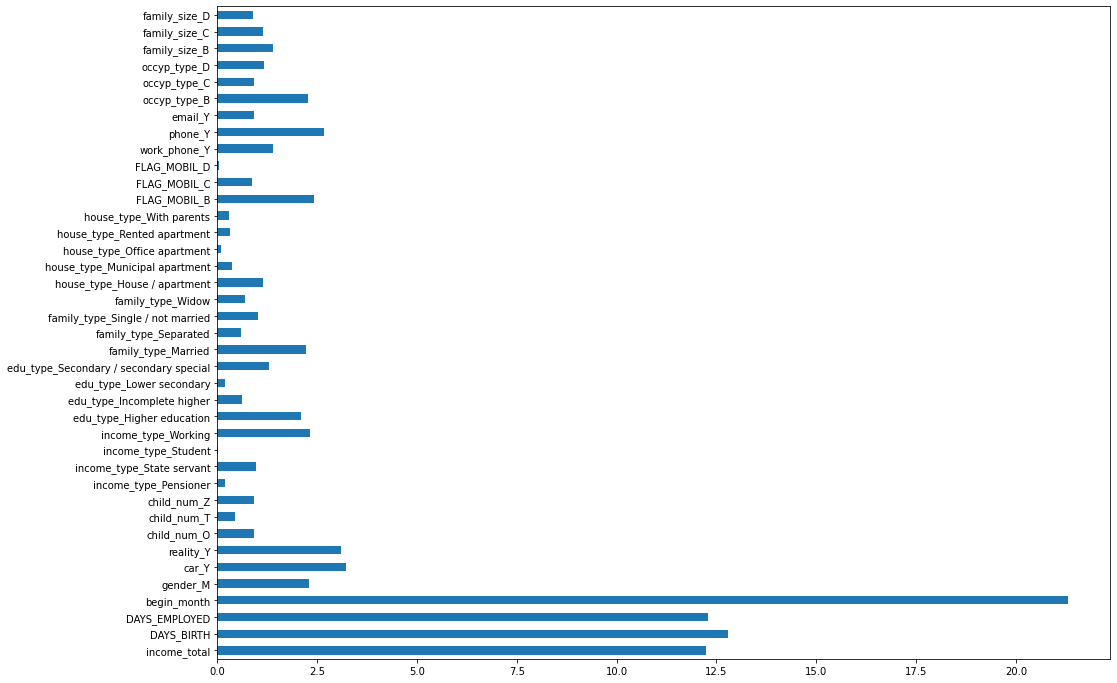

In [409]:
plt.rcParams['figure.figsize'] = (16,12)

pd.Series(cat_pred.feature_importances_, X_train.columns).plot(kind = 'barh')

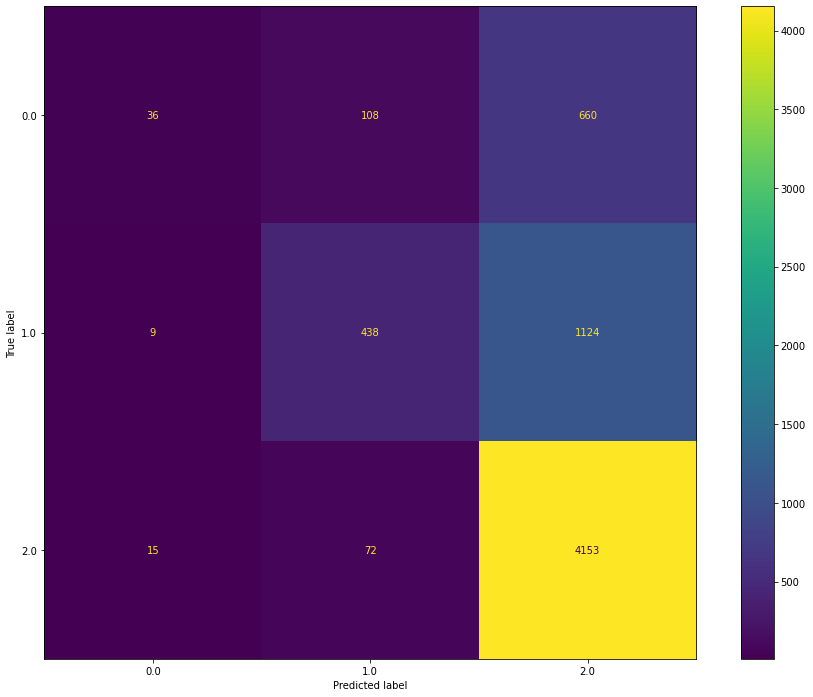

In [410]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(cat_pred, X_val, y_val)
plt.show()

In [282]:
submission.loc[:,1:] = my_submission

In [283]:
submission

,index,0,1,2
0,26457,0.117302,0.149377,0.733321
1,26458,0.296342,0.076629,0.627029
2,26459,0.049856,0.057987,0.892157
3,26460,0.125001,0.115281,0.759718
4,26461,0.051359,0.105162,0.843479
...,...,...,...,...
9995,36452,0.113246,0.133189,0.753565
9996,36453,0.072651,0.164655,0.762694
9997,36454,0.051462,0.092967,0.855571
9998,36455,0.065092,0.129075,0.805833


In [284]:
submission.to_csv('../Data/LJH_LGB_1.csv', index=False)